Found 8000 files belonging to 1 classes.
Using 6400 files for training.
Found 8000 files belonging to 1 classes.
Using 1600 files for validation.


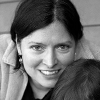

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


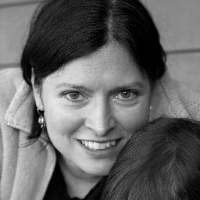

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, None, None, 2 6656        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, None, None, 9 221280      conv2d_187[0][0]                 
__________________________________________________________________________________________________
conv2d_transpose_22 (Conv2DTran (None, None, None, 9 83040       conv2d_188[0][0]                 
___________________________________________________________________________________________

In [28]:
# Setup
import tensorflow as tf
import os
import math
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pylab as pl,PIL

def scale01(img): 
    return img/255

def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    
    return tf.image.resize(y,[img_size,img_size],method='bicubic')

def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    
    return y

# Loading and preparing the dataset
train_high_ds = '/home/cst2/preprocessed_data/train/resized_ds'
validate_high_ds = '/home/cst2/preprocessed_data/validate/resized_ds'

[crop_size,upscale_factor]=[200,2]
input_size=crop_size//upscale_factor
batch_size=8

train_ds=image_dataset_from_directory(
    train_high_ds,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)

valid_ds=image_dataset_from_directory(
    validate_high_ds,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=1234,label_mode=None,)

train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
        
test_path='/home/cst2/preprocessed_data/test/resized_ds/resized'
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])

train_ds=train_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)

valid_ds=valid_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)

for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break
        
# Building the model
def model(upscale_factor=upscale_factor,channels=3):
    conv_args={'activation':'relu','kernel_initializer':'Orthogonal','padding':'same',}
    
    inputs=tf.keras.Input(shape=(None,None,1))
    
    #DSRCNN
    
    x1_1 = layers.Conv2D(256, 5, **conv_args)(inputs)
    x2_1 = layers.Conv2D(96, 3, **conv_args)(x1_1)
    
    x2_2 = layers.Conv2DTranspose(96, 3, **conv_args)(x2_1)
    x2 = layers.Add()([x2_1, x2_2])
        
    x1_2 = layers.Conv2DTranspose(256, 3, **conv_args)(x2)
    x1 = layers.Add()([x1_1, x1_2])
    
    x = layers.Conv2D(32, 3, **conv_args)(x1)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    
    #DDSRCNN
    x1 = layers.Conv2D(64, (3, 3), **conv_args)(x)
    x1 = layers.Conv2D(64, (3, 3), **conv_args)(x1)
    x = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(128, (3, 3), **conv_args)(x)
    x2 = layers.Conv2D(128, (3, 3), **conv_args)(x2)
    x = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(256, (3, 3), **conv_args)(x)
    x = layers.UpSampling2D()(x3)

    x2_2 = layers.Conv2D(128, (3, 3), **conv_args)(x)
    x2_2 = layers.Conv2D(128, (3, 3), **conv_args)(x2_2)

    m1 = layers.Add()([x2, x2_2])
    m1 = layers.UpSampling2D()(m1)

    x1_2 = layers.Conv2D(64, (3, 3), **conv_args)(m1)
    x1_2 = layers.Conv2D(64, (3, 3), **conv_args)(x1_2)

    m2 = layers.Add()([x1, x1_2])

    x = layers.Conv2D(16,(5, 5), activation='linear', padding='same')(m2)
    
    #DBSRCNN
    
    x1 = layers.Conv2D(32, (9, 9), padding="same", kernel_initializer="he_normal", activation="relu")(x)
    x2 = layers.Conv2D(32, (5, 5), padding="same", kernel_initializer="he_normal", activation="relu")(x1)
    
    m = layers.concatenate([x1, x2])
    
    x = layers.Conv2D(channels*(upscale_factor**2),3,**conv_args)(m)
    x = tf.nn.depth_to_space(x, upscale_factor)
    
    return tf.keras.Model(inputs,x)

# Utility functions
## Displaying results
def display_results(img,prefix,title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 150, 200, 150, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.show()

## Low resolution images
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,img.size[1]//upscale_factor)
    
    return img.resize(dimensions,PIL.Image.BICUBIC,)

## Upscaled Images
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge('YCbCr',(out_img_y,out_img_cb,out_img_cr))
    
    return out_img.convert('RGB')

## Callback class with functions on epoch begin, end, and testing batch end
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
        
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))


In [ ]:
# Using Early Stopping 
early_stopping=tkc.EarlyStopping(monitor='loss',verbose=2,patience=10)

# Saving weights and checkpoints
checkpoint_path='/home/cst2/Testing Code/checkpoint/final/'
checkpoint=tkc.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,monitor='loss',mode='min',save_best_only=True,verbose=2)

lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',patience=10,verbose=2,factor=.9)

model=model(upscale_factor=upscale_factor,channels=1)

# Summary of the network architecture
model.summary()

callbacks=[ESPCNCallback(),early_stopping,checkpoint,lr_reduction]

loss_fn=tf.keras.losses.MeanSquaredError()

# Setting the optimizer and learning rate 
optimizer=tf.keras.optimizers.Adam(learning_rate=.0001)

In [30]:
epochs=50

model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'],)

history=model.fit(train_ds,epochs=epochs,callbacks=callbacks,validation_data=valid_ds,verbose=2)

model.load_weights(checkpoint_path)

Epoch 1/50
800/800 - 41s - loss: 0.0086 - accuracy: 0.0044 - val_loss: 0.0012 - val_accuracy: 0.0042
mean PSNR for epoch: 29.11

Epoch 00001: loss improved from inf to 0.00856, saving model to /home/cst2/Testing Code/checkpoint/final/
Epoch 2/50
800/800 - 41s - loss: 0.0011 - accuracy: 0.0045 - val_loss: 8.9942e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 30.34

Epoch 00002: loss improved from 0.00856 to 0.00106, saving model to /home/cst2/Testing Code/checkpoint/final/
Epoch 3/50
800/800 - 41s - loss: 8.6342e-04 - accuracy: 0.0045 - val_loss: 7.9977e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 30.84

Epoch 00003: loss improved from 0.00106 to 0.00086, saving model to /home/cst2/Testing Code/checkpoint/final/
Epoch 4/50
800/800 - 42s - loss: 8.1799e-04 - accuracy: 0.0045 - val_loss: 9.7798e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 30.05

Epoch 00004: loss improved from 0.00086 to 0.00082, saving model to /home/cst2/Testing Code/checkpoint/final/
Epoch 5/50
800/800 - 42s - l

PSNR of low resolution and high resolution is 31.1799
PSNR of predict and high resolution is 31.7934


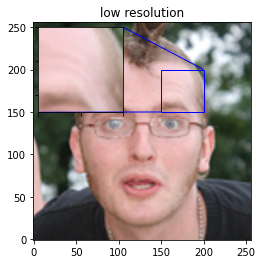

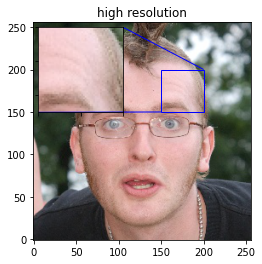

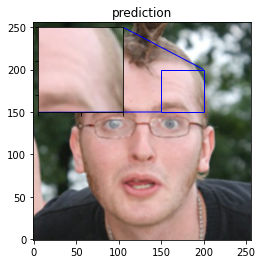

PSNR of low resolution and high resolution is 32.8316
PSNR of predict and high resolution is 33.1537


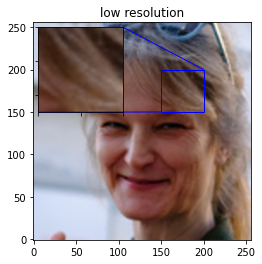

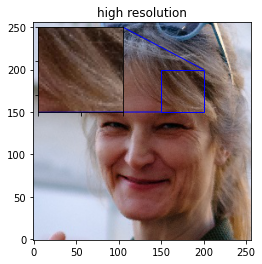

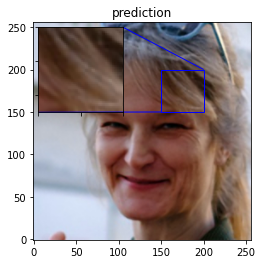

PSNR of low resolution and high resolution is 33.4500
PSNR of predict and high resolution is 33.3688


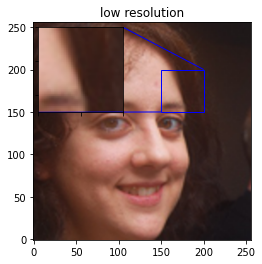

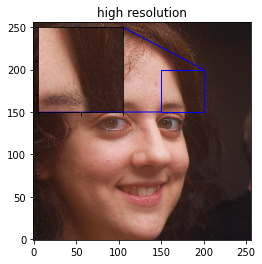

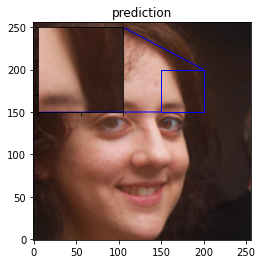

PSNR of low resolution and high resolution is 28.3846
PSNR of predict and high resolution is 29.0057


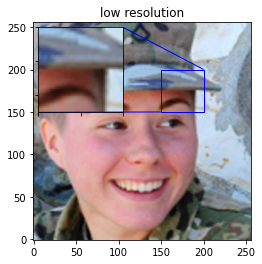

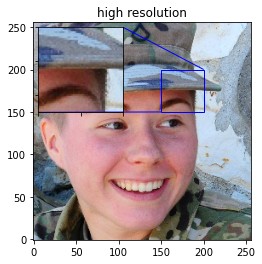

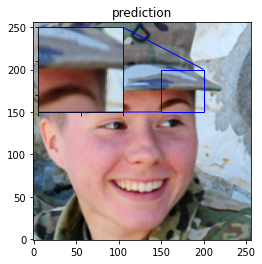

PSNR of low resolution and high resolution is 25.0418
PSNR of predict and high resolution is 25.4214


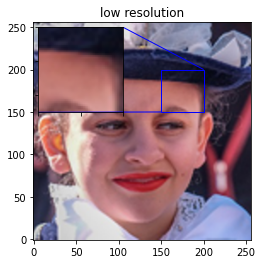

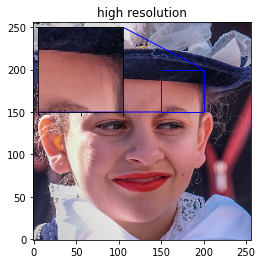

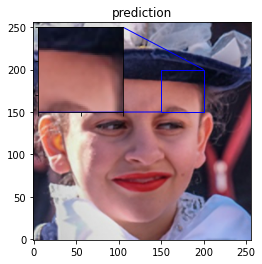

PSNR of low resolution and high resolution is 29.5121
PSNR of predict and high resolution is 30.5310


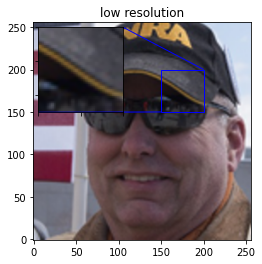

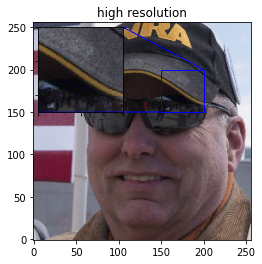

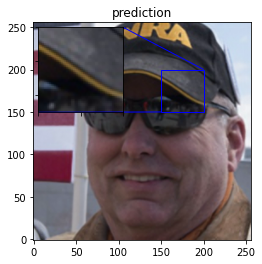

PSNR of low resolution and high resolution is 31.8701
PSNR of predict and high resolution is 32.1200


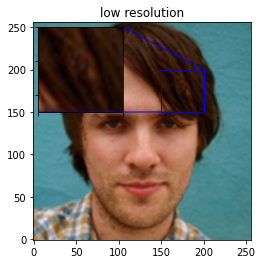

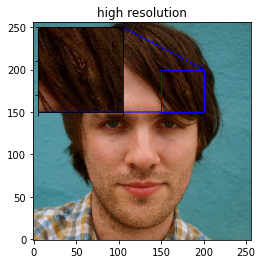

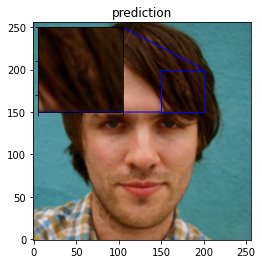

PSNR of low resolution and high resolution is 28.5984
PSNR of predict and high resolution is 28.9231


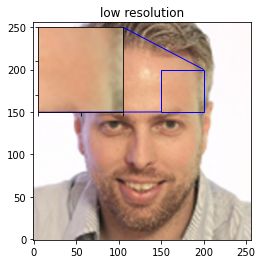

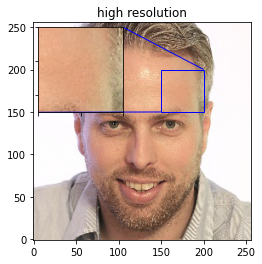

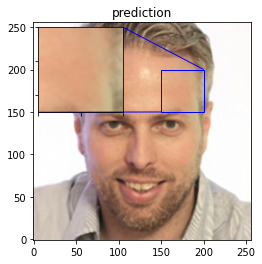

PSNR of low resolution and high resolution is 32.0471
PSNR of predict and high resolution is 32.3535


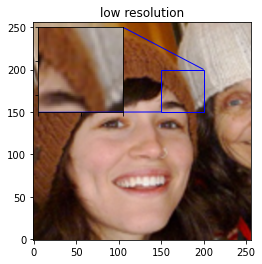

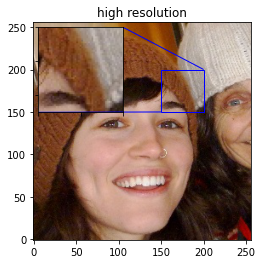

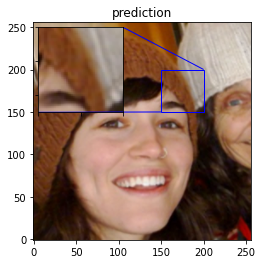

PSNR of low resolution and high resolution is 28.1478
PSNR of predict and high resolution is 28.6627


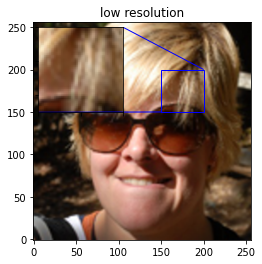

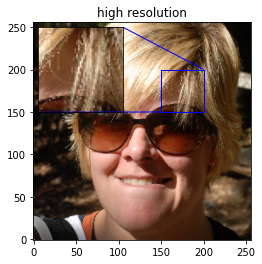

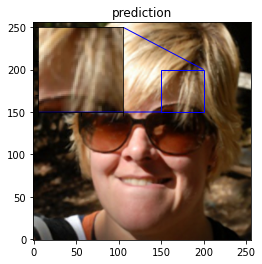

avg. PSNR of images with low resolution is 30.1063
avg. PSNR of reconstructions is 30.5333


In [32]:
total_bicubic_psnr=0. 
total_test_psnr=0.
n_img=10

for index,test_path in enumerate(test_paths[0:n_img]):
    
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    
    highres_img=img.resize((w,h))
    
    predict_img=upscale_img(model,lowres_input)
    
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    
    highres_img_arr=img_to_array(highres_img)
    
    predict_img_arr=img_to_array(predict_img)
    
    bicubic_psnr=tf.image.psnr(lowres_img_arr,highres_img_arr,max_val=255)
    
    test_psnr=tf.image.psnr(predict_img_arr,highres_img_arr,max_val=255)
    
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    
    print('PSNR of low resolution and high resolution is %.4f'%bicubic_psnr)
    
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
    
print('avg. PSNR of images with low resolution is %.4f' %(total_bicubic_psnr/n_img))

print('avg. PSNR of reconstructions is %.4f' %(total_test_psnr/n_img))